In this notebook, we are looking at the paper:

*   Sun, Ming, Zhu, Li: Out-of-Distribution Detection with Deep Nearest Neighbors. 2022, [arXiv:2204.06507](https://arxiv.org/pdf/2204.06507)

in which they introduce an assumption-free method for out-of-distribution detection relying on k-th nearest neighbors. [FAISS](https://github.com/facebookresearch/faiss) library ensures that KNN can be performed quickly, even on a high-dimensional vectors, e.g. here we will work on a image classification and use the last feature map output of the backbone for KNN, or as the author coin it in this setting: *Deep nearest neighbors*.

Specifically, we will use the TissueMNIST dataset (from the [MedMNIST](https://medmnist.com/)) as our playground.

In [1]:
!pip install pytorch_lightning
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 77.6 MB/s eta 0:00:00


The dataset can be downloaded from https://zenodo.org/records/10519652 but I will access it from Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!cp -r drive/MyDrive/tissuemnist_64.npz /content/tissuemnist_64.npz

Mounted at /content/drive


After importing libraries and setting some defaults and hyperparameters, let's look at the classes in this dataset.

cuda


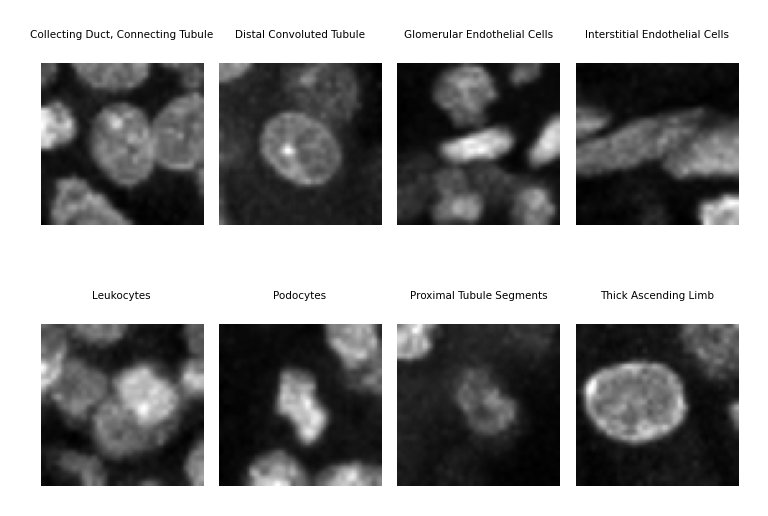

In [3]:
from functools import partial
import glob
import math
import numpy as np
import pandas as pd
from pathlib import Path
import random
import logging

import albumentations as A
import cv2
import faiss
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import timm
import torch
import torch.nn as nn
from torch.nn import ReLU, Linear, Sequential
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, RandomSampler
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 4
plt.rcParams["ytick.labelsize"] = 4
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.minor.size"] = 1
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["legend.fontsize"] = "xx-small"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


dic_cls = {
    0: "Collecting Duct, Connecting Tubule",
    1: "Distal Convoluted Tubule",
    2: "Glomerular Endothelial Cells",
    3: "Interstitial Endothelial Cells",
    4: "Leukocytes",
    5: "Podocytes",
    6: "Proximal Tubule Segments",
    7: "Thick Ascending Limb"
    }

cfg_training0 = {
    "batch_size": 512,
    "epoch_unfreeze_bb": 4,
    "accumulate_batches": 1,
    "scheduler": {
       "lr_init": 1e-4,
       "T_0": 20,
       "T_mult": 1,
       "eta_min": 1e-7
        # "lr_after_warmup": 1e-3,
        # "lr_decay": 0.98,
        # "lr_max": 1.2e-3,
        # "lr_min": 1e-6,
        # "warmup_epochs": 4,
        # "f_reduction": 0.25,
        # "f_restart": 1.0,
        # "patience": 3,
        # "min_loss_improvement": 0.5 / 100,
        # "no_of_restarts_init": 1,
        # "increment_no_of_restarts": 0.5,
        }
    }

cfg_training1 = {
    "epochs": 100,
    "patience_es": 25
    }

cfg_model = {
    "model_name": "resnet18",
    "pretrained": False,
    "dropout": 0.3,
    "bb_in": (1, 64, 64),
    "n_cls": len(dic_cls)
    }

def display_img(
    img_lst, titles_lst=None, n_cols=4, figsize=(3, 2), means=None, stds=None
    ):
    n_rows = math.ceil(len(img_lst) / n_cols)

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(
        nrows=n_rows,
        ncols=n_cols,
        figure=fig,
        wspace=0.1,
        hspace=0.3
        )

    for idx, img in enumerate(img_lst):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        if means is not None and stds is not None:
            img = np.clip(img * stds + means, 0, 1)
        ax.imshow(img, cmap="gray")
        if titles_lst is not None:
            ax.set_title(titles_lst[idx], fontsize=2.5)
        ax.set_axis_off()

    plt.show()


data = np.load("tissuemnist_64.npz")
X_train, y_train = data["train_images"][:, :, :, None], data["train_labels"]
X_val, y_val = data["val_images"][:, :, :, None], data["val_labels"]
X_test, y_test = data["test_images"][:, :, :, None], data["test_labels"]


def range_groups(start, end, step):
    members = list(range(start, end))
    groups = (members[i:i+step] for i in range(0, len(members), step))
    return groups


def apply_batch_np_func(X, func, batch_size):
    val, count = 0, 0
    for group in range_groups(0, X_train.shape[0], batch_size):
        batch = X_train[group]
        val += func(batch)
        count += batch.shape[0]
    return val / count


mean_train = apply_batch_np_func(
    X_train / 255, partial(np.mean, axis=(0, 1, 2)), 512)
std_train = apply_batch_np_func(
    X_train / 255, partial(np.mean, axis=(0, 1, 2)), 512)

cls_train, cls_idxs_train, cls_counts_train = np.unique(
    y_train, return_index=True, return_counts=True)

display_img(
    img_lst=[X_train[x] for x in cls_idxs_train],
    titles_lst=[dic_cls.get(x) for x in cls_train]
    )

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


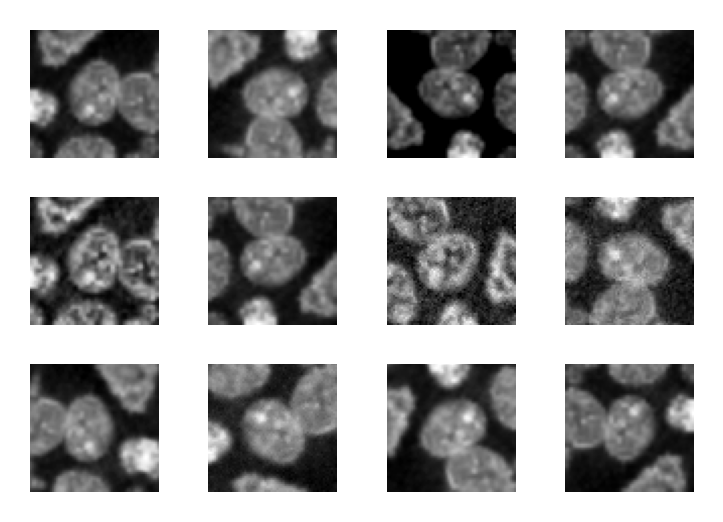

In [4]:
def preprocess_img(img, transforms):
    img_aug = transforms(image=img)["image"]
    img_aug = torch.from_numpy(img_aug).permute(2, 0, 1)
    return img_aug.type(torch.float32)


class CustomDataset(Dataset):
    def __init__(self, X, y, dic_cls, transforms):
        self.X = X
        self.y = y
        self.n_cls = len(dic_cls)

        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img_aug = preprocess_img(self.X[idx], self.transforms)
        y = torch.tensor(self.y[idx], dtype=torch.long).squeeze()
        return img_aug, y


transforms_train = A.Compose([
    A.OneOf([
        A.RandomCropFromBorders(
            crop_left=0.1,
            crop_right=0.1,
            crop_top=0.1,
            crop_bottom=0.1,
            p=1.0
            ),
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.1,
            rotate_limit=25,
            border_mode=cv2.BORDER_REFLECT,
            p=1.0
            ),
        ], p=0.4),
    A.OneOf([
        A.RandomBrightnessContrast([-0.1, 0.1], p=1.0),
        A.RandomGamma(gamma_limit=(80, 160), p=1.0),
        A.CLAHE(p=1.0)
        ], p=0.4),
    A.GaussNoise(std_range=[0.0, 0.05], p=0.2),
    A.D4(p=1),
    A.Resize(cfg_model.get("bb_in")[1], cfg_model.get("bb_in")[2], p=1.0),
    A.Normalize(mean=mean_train, std=std_train, max_pixel_value=255.0, p=1.0)
    ])
transforms_val = A.Compose([
    A.Resize(cfg_model.get("bb_in")[1], cfg_model.get("bb_in")[2], p=1.0),
    A.Normalize(mean=mean_train, std=std_train, max_pixel_value=255.0, p=1.0)
    ])

ds_train = CustomDataset(X_train, y_train, dic_cls, transforms_train)
ds_val = CustomDataset(X_val, y_val, dic_cls, transforms_val)


display_img(
    img_lst=[ds_train[0][0].permute(1, 2, 0).numpy() for _ in range(12)],
    figsize=(3, 2), means=mean_train, stds=std_train
    )

In [5]:
sampler_train = RandomSampler(
    data_source=ds_train,
    replacement=False,
    num_samples=X_train.shape[0]
    )

loader_train = DataLoader(
    dataset=ds_train,
    batch_size=cfg_training0.get("batch_size"),
    sampler=sampler_train,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    # shuffle=True
    )
loader_val = DataLoader(
    dataset=ds_val,
    batch_size=cfg_training0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

In [6]:
class MLP(nn.Module):
    def __init__(self, neurons, dropout=0.0, activation=nn.ReLU):
        super().__init__()
        modules = []
        for i in range(len(neurons) - 1):
            modules.append(nn.Linear(neurons[i], neurons[i+1]))
            if i != len(neurons) - 2:
                modules.append(activation())
                modules.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*modules)
        self.apply(self._initialize)

    def forward(self, x):
        return self.mlp(x)

    def _initialize(self, module):
        for m in module.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

class CombinedPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.adaptive_max_pool = nn.AdaptiveMaxPool2d(1)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x1 = self.adaptive_max_pool(x).squeeze(-1).squeeze(-1)
        x2 = self.adaptive_avg_pool(x).squeeze(-1).squeeze(-1)
        return torch.cat((x1, x2), dim=1)


class CNNClassifier(nn.Module):
    def __init__(self, model_name, dropout, bb_in, n_cls, pretrained=False):
        super().__init__()
        self.bb = timm.create_model(
                model_name=model_name,
                pretrained=pretrained,
                features_only=True,
                in_chans=bb_in[0],
                out_indices=(-1,),
                )
        self.bb_out = self.bb.feature_info.channels()[-1]

        self.pooling = CombinedPooling()
        self.dropout = dropout
        self.mlp = MLP([
            self.bb_out * 2,
            self.bb_out * 4,
            self.bb_out * 2,
            n_cls
            ])

        if pretrained:
            self._freeze_bb()
        else:
            self._initialize_backbone_weights(self.bb)

    def forward(self, x):
        x = self.bb(x)[-1]
        x = self.pooling(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.mlp(x)
        return x

    def _freeze_bb(self):
        for p in self.bb.parameters():
            p.requires_grad = False

        for m in self.bb.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        print("Freezing backbone")

    def _unfreeze_bb(self):
        for p in self.bb.parameters():
            p.requires_grad = True
        print("Unfreezing backbone")

    def _initialize_backbone_weights(self, module):
        for m in module.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

In [7]:
# class MultiplicativeDecayWithReduceOrRestartOnPlateau:
#     def __init__(
#             self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min,
#             warmup_epochs, f_reduction, f_restart, patience,
#             min_loss_improvement, no_of_restarts_init,
#             increment_no_of_restarts):
#         self.optimizer = optimizer
#         self.lr_after_warmup = lr_after_warmup
#         self.lr_decay = lr_decay
#         self.lr_max = lr_max
#         self.lr_min = lr_min
#         self.warmup_epochs = warmup_epochs
#         self.f_reduction = f_reduction
#         self.f_restart = f_restart
#         self.patience = patience
#         self.min_loss_improvement = min_loss_improvement
#         self.no_of_restarts_init = no_of_restarts_init
#         self.increment_no_of_restarts = increment_no_of_restarts

#         self.loss_best = np.Inf
#         self.plateau_epochs = 0
#         self.reductions_counter = 0
#         self.just_restarted = False
#         self.set_par("initial_lr", self.lr_min)
#         self.set_par("lr", self.lr_min)
#         self.epoch = 0

#     def get_par(self, name):
#         for group in self.optimizer.param_groups: par = group[name]
#         return par

#     def set_par(self, name, value):
#         for group in self.optimizer.param_groups: group[name] = value

#     def on_loss_improvement(self, loss_cur):
#         self.loss_best = loss_cur
#         self.plateau_epochs = 0

#     def on_loss_deterioration(self):
#         self.plateau_epochs += 1

#     def multiplicative_decay_lr(self, lr):
#         return lr * self.lr_decay

#     def on_plateau(self, lr):
#         if self.reductions_counter >= round(self.no_of_restarts_init):
#             lr_new = self.restart_lr()
#         else:
#             lr_new = self.steep_reduce_lr(lr)
#         return lr_new

#     def steep_reduce_lr(self, lr):
#         lr_new = lr * self.f_reduction
#         self.plateau_epochs = 0
#         self.reductions_counter += 1
#         return lr_new

#     def restart_lr(self):
#         self.lr_after_warmup *= self.f_restart
#         lr_new = self.lr_after_warmup
#         if lr_new > self.lr_max:
#             lr_new = self.lr_max
#         self.plateau_epochs = 0
#         self.reductions_counter = 0
#         self.no_of_restarts_init += self.increment_no_of_restarts
#         self.just_restarted = True
#         return lr_new

#     def warmup(self):
#         lr_new = self.lr_min + (self.lr_after_warmup - self.lr_min) * (
#             self.epoch / self.warmup_epochs)
#         return lr_new

#     def step(self, metrics):
#         if self.epoch <= self.warmup_epochs:
#             lr_new = self.warmup()
#         else:
#             lr_cur = self.get_par("lr")
#             loss_cur = float(metrics)

#             if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
#                 self.on_loss_improvement(loss_cur)
#             else:
#                 self.on_loss_deterioration()
#             lr_new = self.multiplicative_decay_lr(lr_cur)

#             if self.just_restarted:
#                 self.loss_best = loss_cur
#                 self.just_restarted = False

#             if self.plateau_epochs >= self.patience:
#                 lr_new = self.on_plateau(lr_cur)

#             if lr_new <= self.lr_min:
#                 lr_new = self.restart_lr()

#         self.set_par("lr", lr_new)
#         self.epoch += 1


class CNNClassifierModule(pl.LightningModule):
    def __init__(self, cfg_model, cfg_training):
        super().__init__()
        self.automatic_optimization = False
        self.model = CNNClassifier(**cfg_model)
        self.cfg_training = cfg_training

    def forward(self, batch):
        return self.model(batch)

    def on_train_epoch_start(self):
        if self.current_epoch == self.cfg_training.get("epoch_unfreeze_bb"):
            self.model._unfreeze_bb()

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        img, y_true = batch[0], batch[1]
        y_pred = self.forward(img)

        loss = F.cross_entropy(y_pred, y_true)
        self.log(
            "train_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            batch_size=self.cfg_training.get("batch_size")
            )
        self.manual_backward(loss)

        if (batch_idx + 1) % self.cfg_training.get("accumulate_batches") == 0:
            opt.step()
            opt.zero_grad()
        return loss

    def validation_step(self, batch, batch_idx):
        img, y_true = batch[0], batch[1]
        y_pred = self.forward(img)

        loss = F.cross_entropy(y_pred, y_true)
        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            batch_size=self.cfg_training.get("batch_size")
            )

        if batch_idx == 0:
            self.loss_cur = []
        self.loss_cur.append(loss)
        return loss

    def on_validation_epoch_end(self):
        self.scheduler.step()

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.cfg_training.get("scheduler").get("lr_init")
            )
        self.scheduler = CosineAnnealingWarmRestarts(
            optimizer=opt,
            T_0=self.cfg_training.get("scheduler").get("T_0"),
            T_mult=self.cfg_training.get("scheduler").get("T_mult"),
            eta_min=self.cfg_training.get("scheduler").get("eta_min")
            )
        return opt

    # def on_validation_epoch_end(self):
    #     self.scheduler.step(torch.stack(self.loss_cur).mean())

    # def configure_optimizers(self):
    #     opt = torch.optim.Adam(
    #         self.parameters(),
    #         lr=self.cfg_training.get("scheduler").get("lr_min"),
    #         # weight_decay=self.cfg_training.get("weight_decay"),
    #         )
    #     self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
    #         optimizer=opt,
    #         **self.cfg_training.get("scheduler")
    #         )
    #     return opt


module = CNNClassifierModule(cfg_model, cfg_training0)

cb_a = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=cfg_training1.get("patience_es")
    )
cb_c = LearningRateMonitor(logging_interval="epoch")
logger = CSVLogger(save_dir="logs/", name="run01", flush_logs_every_n_steps=1)

trainer = pl.Trainer(
    max_epochs=cfg_training1.get("epochs"),
    check_val_every_n_epoch=1,
    callbacks=[cb_a, cb_b, cb_c],
    logger=logger,
    accelerator=device,
    enable_progress_bar=True
    )
trainer.fit(
    model=module,
    train_dataloaders=loader_train,
    val_dataloaders=loader_val
    )

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ CNNClassifier │ 15.4 M │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 15.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.4 M                                                                                               
Total estimated model params size (MB): 61                                                                         
Modules in train mode: 103                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Unfreezing backbone

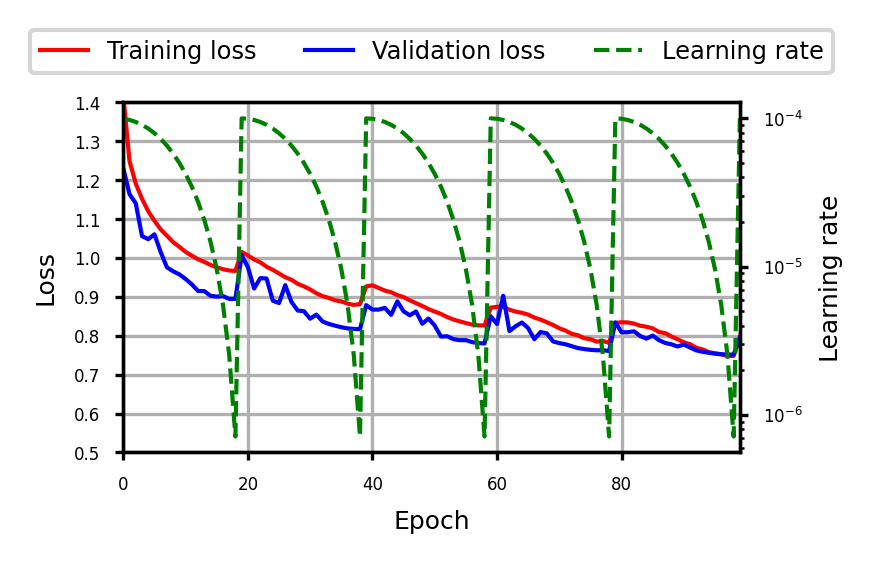

In [8]:
def display_training_progress(trainer, y_lim, figsize=(3, 2)):
    logs = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig, ax0 = plt.subplots(figsize=figsize)
    l0 = ax0.plot(epochs, logs["train_loss"].dropna(), color="r",
                  label="Training loss")
    l1 = ax0.plot(epochs, logs["val_loss"].dropna(), color="b",
                  label="Validation loss")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.set_xlim(0, len(epochs)-1)

    ax1 = ax0.twinx()
    l2 = ax1.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed",
        label="Learning rate")
    ax1.set_ylabel("Learning rate")
    ax1.set_yscale("log")
    ax0.set_ylim(y_lim[0], y_lim[1])
    ax0.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center",
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.tight_layout()
    ax0.grid()
    plt.show()


display_training_progress(trainer, [0.5, 1.4])


In [9]:
checkpoint_file = trainer.checkpoint_callback.best_model_path
module_best = CNNClassifierModule.load_from_checkpoint(
    checkpoint_file, cfg_model=cfg_model, cfg_training=cfg_training0)


model_best = module_best.model
_ = model_best.eval()
torch.save(model_best, "./drive/MyDrive/model_best.pt")

In [10]:
model_best = torch.load(
    "./drive/MyDrive/model_best.pt", map_location=device, weights_only=False)
_ = model_best.eval()

ds_test = CustomDataset(X_test, y_test, dic_cls, transforms_val)
loader_test = DataLoader(
    dataset=ds_test,
    batch_size=cfg_training0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

y_test_pred = []
with torch.no_grad():
    for batch_idx, (img_batch, y_batch) in enumerate(loader_test):
        img_batch = img_batch.to(device)

        y_pred_batch = F.softmax(model_best(img_batch), dim=1)
        y_test_pred.append(y_pred_batch.cpu().numpy())

y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_pred_hard = y_test_pred.argmax(1)

In [11]:
def metrics_per_class(y_true, y_pred, dic_cls):
    cm = confusion_matrix(y_true, y_pred).astype(np.float32)
    acc_per_class = np.zeros((len(dic_cls),), dtype=np.float32)
    fpr_per_class = np.zeros((len(dic_cls),), dtype=np.float32)

    for idx in range(len(dic_cls)):
        tp = cm[idx, idx]
        fp = cm[:, idx].sum() - tp
        fn = cm[idx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        acc = (tp + tn) / (tp + tn + fp + fn)
        acc_per_class[idx] = (tp + tn) / (tp + tn + fp + fn)

        fpr_per_class[idx] = np.divide(fp, (fp + tn), out=np.zeros_like(fp), where=(fp + tn)!=0)
    return acc_per_class.round(3), fpr_per_class.round(3)


auc_score = roc_auc_score(
    y_test.flatten(), y_test_pred, multi_class="ovr", average="macro")
accuracy = accuracy_score(y_test.flatten(), y_test_pred_hard)
acc_per_class, fpr_per_class = metrics_per_class(
    y_test.flatten(), y_test_pred_hard, dic_cls)

print(f"AUC: {auc_score:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Accuracy per class: {acc_per_class}")
print(f"FPR per class: {fpr_per_class}")

AUC: 0.948
Accuracy: 0.729
Accuracy per class: [0.878 0.96  0.969 0.939 0.947 0.96  0.892 0.912]
FPR per class: [0.099 0.011 0.017 0.038 0.028 0.021 0.071 0.051]


Finally, let's start the out-of-distribution evaluation:

In [12]:
idx_sample_index = rng.choice(a=np.arange(0, X_train.shape[0]), size=10000)
idx_sample_thresholding = idx_sample_index[5000:]
idx_sample_index = idx_sample_index[:5000]


ds_train_index = CustomDataset(
    X_train[idx_sample_index], y_train[idx_sample_index], dic_cls, transforms_val)
loader_train_index = DataLoader(
    dataset=ds_train_index,
    batch_size=cfg_training0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

ds_train_thresholding = CustomDataset(
    X_train[idx_sample_thresholding], y_train[idx_sample_thresholding], dic_cls, transforms_val)
loader_train_thresholding = DataLoader(
    dataset=ds_train_thresholding,
    batch_size=cfg_training0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

def get_embedding(model, loader):
    embeddings = []
    ys = []
    with torch.no_grad():
        for batch_idx, (img_batch, y_batch) in enumerate(loader):
            img_batch = img_batch.to(device)
            tmp = model_best.bb(img_batch)[-1]
            tmp = CombinedPooling()(tmp)
            tmp = F.normalize(tmp, dim=1)
            embeddings.append(tmp)
            ys.append(y_batch)

    embeddings = torch.concat(embeddings, axis=0).cpu().numpy().astype(np.float32)
    ys = torch.concat(ys, axis=0).cpu().numpy().astype(np.float32)
    return embeddings, ys

embeddings_train_index, ys_train_index = get_embedding(model_best, loader_train_index)
embeddings_train_thresholding, ys_train_thresholding = get_embedding(model_best, loader_train_thresholding)
embeddings_test, ys_test = get_embedding(model_best, loader_test)


dim = embeddings_train_index.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_train_index)

k = 10

distances_tresholding, _ = index.search(embeddings_train_thresholding, k)
scores_thresholding = distances_tresholding[:, -1]
threshold = np.percentile(scores_thresholding, 90)

distances_test, _ = index.search(embeddings_test, k)
scores_test = distances_test[:, -1]
ood_test = scores_test > threshold

y_test_id = y_test[~ood_test]
y_test_pred_id = y_test_pred[~ood_test]
y_test_pred_hard_id = y_test_pred_hard[~ood_test]

In [13]:
y_test_id, y_test_pred_id, y_test_pred_hard_id = y_test[~ood_test], y_test_pred[~ood_test], y_test_pred_hard[~ood_test]

auc_score_id = roc_auc_score(
    y_test_id.flatten(), y_test_pred_id, multi_class="ovr", average="macro")
accuracy_id = accuracy_score(y_test_id.flatten(), y_test_pred_hard_id)
acc_per_class_id, fpr_per_class_id = metrics_per_class(
    y_test_id.flatten(), y_test_pred_hard_id, dic_cls)

print(f"AUC: {auc_score_id:.3f}")
print(f"Accuracy: {accuracy_id:.3f}")
print(f"Accuracy per class: {acc_per_class_id}")
print(f"FPR per class: {fpr_per_class_id}")

AUC: 0.957
Accuracy: 0.763
Accuracy per class: [0.878 0.959 0.976 0.962 0.968 0.972 0.896 0.913]
FPR per class: [0.104 0.011 0.014 0.022 0.015 0.013 0.072 0.053]


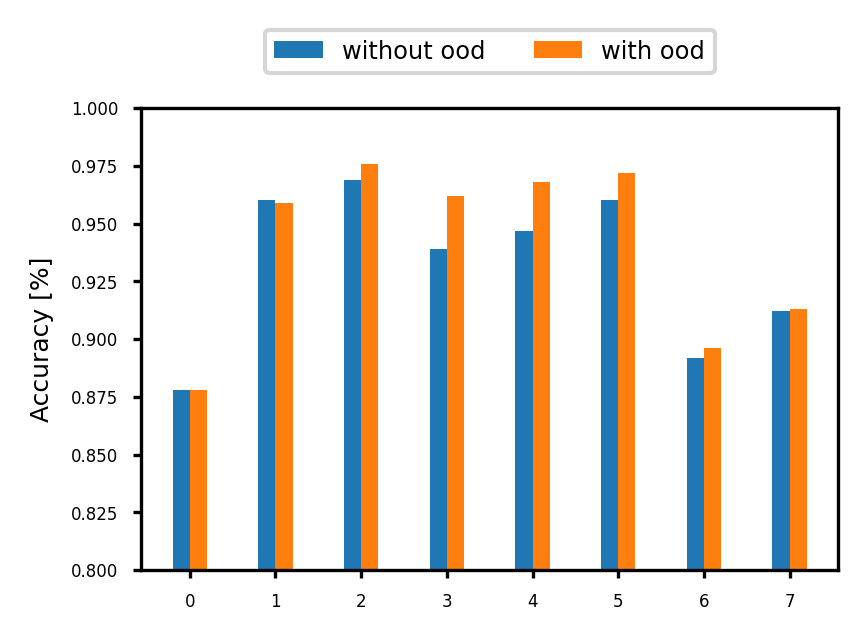

In [14]:
comparison = np.stack([acc_per_class, acc_per_class_id], axis=0).T
labels = ["without ood", "with ood"]
n_groups, n_bars = comparison.shape
x = np.arange(n_groups)


ls = []
width = 0.2
fig, ax = plt.subplots(figsize=(3, 2))
for i in range(n_bars):
    l = ax.bar(
        x=x + (i - (n_bars - 1) / 2) * width,
        height=comparison[:, i],
        width=width,
        label=f"{labels[i]}"
    )
    ls.append(l)

ax.set_ylim([0.8, 1.0])
plt.xticks(x, dic_cls.keys())
plt.ylabel("Class")
plt.ylabel("Accuracy [%]")
ax.legend(ls, [l.get_label() for l in ls], loc="lower center",
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
plt.show()

There is a clear positive effect on accuracy by removing (potential) out-of-distribution test images with deep nearest neighbors.

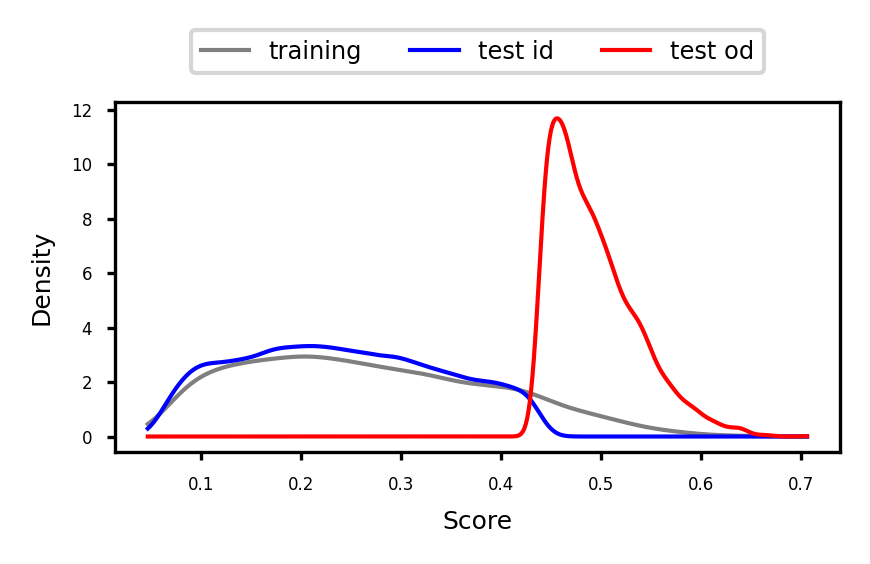

In [15]:
scores_test_ood = distances_test[ood_test][:, -1]
scores_test_id = distances_test[~ood_test][:, -1]
scores_all = np.concatenate([scores_thresholding, scores_test_ood, scores_test_id])

kde_train = gaussian_kde(scores_thresholding)
kde_test_id = gaussian_kde(scores_test_id)
kde_test_ood = gaussian_kde(scores_test_ood)

x_grid = np.linspace(np.min(scores_all), np.max(scores_all), 1000)

fig, ax = plt.subplots(figsize=(3, 2))
l0 = ax.plot(x_grid, kde_train(x_grid), color="k", alpha=0.5, label="training")
l1 = ax.plot(x_grid, kde_test_id(x_grid), color="b", label="test id")
l2 = ax.plot(x_grid, kde_test_ood(x_grid), color="r", label="test od")
ax.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center",
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
ax.set_xlabel("Score")
ax.set_ylabel("Density")
plt.tight_layout()
plt.show()